The problem statement:
https://gym.openai.com/envs/MsPacman-v0

In [11]:
%load_ext autoreload
%autoreload 2

import gym
import random
import torch
from torchvision import transforms

import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from DDQN_agent_Atari_3D_PReplay_Tree import Agent
from myWrappers import StackEnv

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You are using pip version 18.0, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Original Gym Env basic info
game_title = 'MsPacman-v0'
env = gym.make(game_title)
env.seed(0)
state_space = env.observation_space.shape
action_space = env.action_space.n

# config
action_allowed = 5
input_shape = (84,84)
states_stack_depth = 4
mergeframes = 2

print('State shape: ', state_space)
print('Number of actions: ', action_space)
print("List of available actions: ", env.unwrapped.get_action_meanings())
print("Number of lives", env.unwrapped.ale.lives())

State shape:  (210, 160, 3)
Number of actions:  9
List of available actions:  ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
Number of lives 3


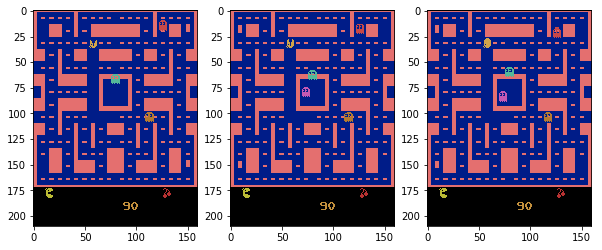

In [3]:
#import images
s = env.reset()
s0, s1, s2 = None, None, None

sampleframe = 240

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6)) 
for i in range(1000):
    s, r, d, _ = env.step(1)
    if i == sampleframe:
        s0 = s
    if i == (sampleframe+1):
        s1= s
    if i == (sampleframe+2):
        s2= s
ax1.imshow(s0)
ax2.imshow(s1)
ax3.imshow(s2)

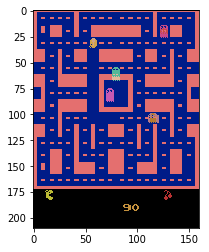

In [4]:
plt.imshow(np.max((s1,s2),axis=0))

ending frame:  197


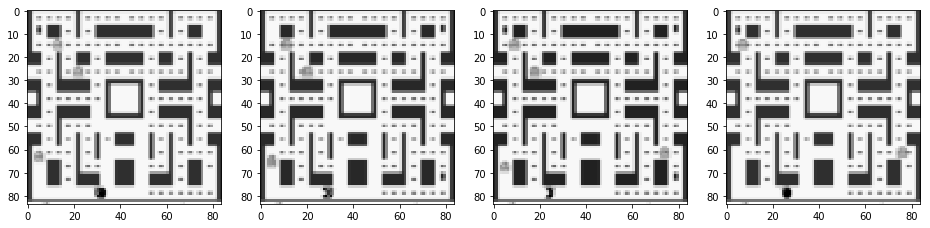

In [5]:
#to get all the preprosing logic done in this class
from myWrappers import StackEnv
stackenv = StackEnv(gym.make(game_title), skipframes=4, mergeframes=mergeframes)

#import images
s = stackenv.reset()
s0, s1, s2 = None, None, None

sampleframe = 15

frame_dq = deque(maxlen=100)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,8)) 
i = 0
d = False
while not d:
    if i == sampleframe:
        printState = True
    else:
        printState = False
    s, r, d, l = stackenv.step(np.random.choice(5))
    frame_dq.append(s)
    i += 1
print("ending frame: ",i)
ax1.imshow(frame_dq[sampleframe][0,:,:], cmap='Greys')
ax2.imshow(frame_dq[sampleframe][1,:,:], cmap='Greys')
ax3.imshow(frame_dq[sampleframe][2,:,:], cmap='Greys')
ax4.imshow(frame_dq[sampleframe][3,:,:], cmap='Greys')

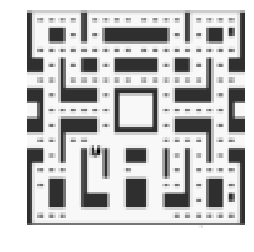

In [6]:
untrained_agent = Agent(state_size=states_stack_depth, action_size=action_allowed, seed=10)

fig, ax = plt.subplots(figsize=(4, 4))

# watch an untrained agent
stackenv = StackEnv(gym.make(game_title), skipframes=4, mergeframes=mergeframes)
state_inputs = stackenv.reset()

img = ax.imshow(stackenv.render(proccessed=True), cmap='Greys')
for j in range(1000):
    action = np.random.choice(action_space)
    img.set_data(stackenv.render(proccessed=True)) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    next_state_inputs, reward, done, life_lost = stackenv.step(action)
    state_inputs = next_state_inputs
    
    if done:
        break 
        
stackenv.close()

In [7]:
def loadTrainedModel(agent, path, loadoptimizer=True):
    state_dicts = torch.load(path)
    print(state_dicts['model'].keys())

    agent.qnetwork_local.load_state_dict(state_dicts['model'])
    if loadoptimizer:
        agent.optimizer.load_state_dict(state_dicts['optimizer'])
    
    return agent, state_dicts['eps'], state_dicts['n_episodes'], state_dicts['i_episode']

In [8]:
def saveTrainedModel(agent, path, eps, n_episodes, i_episode):
    state_dicts = {'model': agent.qnetwork_local.state_dict(), 
                   'optimizer': agent.optimizer.state_dict(),
                   'eps': eps, 
                   'n_episodes': n_episodes,
                   'i_episode': i_episode
                  }
    torch.save(state_dicts, path)

In [12]:
model_dir = 'saved_models/'
model_name = 'MsPacman-v1-3D-clipped-loss.pt'

agent = Agent(state_size=states_stack_depth, action_size=action_allowed, seed=0)
print(agent.qnetwork_local)

loadSavedModel = False

if loadSavedModel == True:
    agent, eps, n_episodes, i_episode = loadTrainedModel(agent, model_dir+model_name, False)
    eps = 1.0
    n_episodes = 10000
    i_episode = 1
else:
    eps = 1.0
    n_episodes = 10000
    i_episode = 1

current device: cpu
use duel network (a and v): True
use double network: True
use reward scaling: True
use error clipping: True
use grad clipping: True
use Tree Sum: True
buffer size: 1000
batch size: 32
Gamma: 0.999
initial learning rate: 0.0001
learing rate decay: True
min replay size: 1000
target network update: 10000
optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    momentum: 0
    weight_decay: 0
)
QNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1a): Linear(in_features=3136, out_features=512, bias=True)
  (fc3a): Linear(in_features=512, out_features=5, bias=True)
  (fc1v): Linear(in_features=3136, out_features=512, bias=True)
  (fc3v): Linear(in_features=512, out_features=1, bias=True)
)


In [13]:
def dqn_3D(n_episodes=1000, i_episode=1, max_t=1000, eps_start=1.0, eps_end=0.10, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    stackenv = StackEnv(gym.make(game_title), depth=states_stack_depth, skipframes=4, mergeframes=mergeframes)
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    frame_counter = 0                  # keep track of number of frames seen
    
    eps = eps_start                    # initialize epsilon 
    eps_decay = 0.9995                 # make sure decay come to min 
    max_score = -np.inf
    done = True
    
    while i_episode < n_episodes + 1:
        
        if done: # only reset when there is a game over
            state_inputs = stackenv.reset()    
        score = 0

        for t in range(max_t):

            action = agent.act(state_inputs, eps) #for action recommendation
            
            next_state_inputs, reward, done, life_lost = stackenv.step(action)
            
            frame_counter += 1
            
            agent.step(state_inputs , action, reward, next_state_inputs, done, (i_episode,n_episodes))
            
            state_inputs = next_state_inputs
            
            score += reward
            
            if done or life_lost:
                break 
                
        if agent.isTraining == True:     #learning starts   
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score

            eps = max(eps_end, eps_decay*eps) # decay epsilon

            print('\rEpisode: {}\tAvg Score: {:.2f}\tb: {:.3f}'.format(i_episode, 
                                                                       np.mean(scores_window),
                                                                       agent.p_replay_beta
                                                                      ), end="")
            #save scores if there is a new max
            if i_episode > 100 and np.mean(scores_window) > max_score:
                max_score = np.mean(scores_window)
                saveTrainedModel(agent, model_dir+model_name, eps, n_episodes, i_episode)
                print('')
                print('New max avg score {:.2f} found. Model saved.'.format(max_score))
                
            if i_episode % 100 == 0:
                latest_lr = agent.optimizer.state_dict()['param_groups'][0]['lr']
                td_s = agent.memory.tree.total_td_score

                print(('\rEpisode: {}\tAvg Score: {:.2f}  steps: {}  eps: {:.2f}  lr: {:1.2e}'
                       '\tp:{:.1f}  b:{:.2f}  td:{:.2f}  avg Q:{:.2f}').format(i_episode, np.mean(scores_window),
                                                                               agent.t_step, eps, latest_lr, 
                                                                               agent.p_replay_alpha, 
                                                                               agent.p_replay_beta,
                                                                               td_s,
                                                                               agent.getQAverage(), end=""))


            if np.mean(scores_window)>=2500.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                             np.mean(scores_window)))

                saveTrainedModel(agent, model_dir+model_name, eps, n_episodes, i_episode)
                break
            
            i_episode += 1
        else:
            print('\rTraining to be started... Steps: {} '.format(agent.t_step), end="")

    stackenv.close()
        
    return scores

scores = dqn_3D(n_episodes, i_episode=i_episode, eps_start=eps)

Training to be started... Steps: 957 current device: cpu
use duel network (a and v): True
use double network: True
use reward scaling: True
use error clipping: True
use grad clipping: True
use Tree Sum: True
buffer size: 1000
batch size: 32
Gamma: 0.999
initial learning rate: 0.0001
learing rate decay: True
min replay size: 1000
target network update: 10000
optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    momentum: 0
    weight_decay: 0
)
Prefetch completed. Training starts!                         
Episode: 7	Avg Score: 104.29	b: 0.301

KeyboardInterrupt: 

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

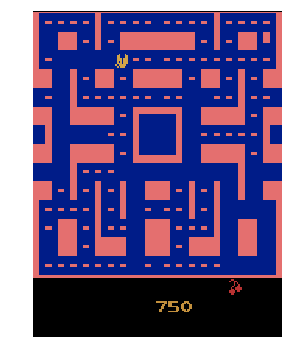

In [12]:
# load the weights from file
#torch.load(agent.qnetwork_local.state_dict(), model_dir+model_name)
fig, ax = plt.subplots(figsize=(5, 5))

stackenv = StackEnv(gym.make(game_title), mergeframes=mergeframes)

agent.qnetwork_local.eval()
agent.qnetwork_target.eval()

for i in range(3):
    # watch an untrained agent
    state_inputs = stackenv.reset()  
    
    img = ax.imshow(stackenv.render(proccessed=True), cmap='Greys')
    for j in range(1000):
        action = agent.act(state_inputs)
        img.set_data(stackenv.render(proccessed=True)) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        next_state_inputs, reward, done, _ = stackenv.step(action)
        
        state_inputs = next_state_inputs
        
        if done:
            break 

agent.qnetwork_local.train()
#agent.qnetwork_target.train()
            
stackenv.env.close()

In [126]:
from sumTree import SumTree

In [127]:
tree = SumTree(4)

In [128]:
for i in np.arange(1,5,1):
    tree.add(i,str(i))
    print(i)

1
2
3
4


In [129]:
tree.tree[0]

10.0

In [141]:
tree.get_leaf(6)

(5, 3.0, '3')

In [75]:
tree.update(6,'6.1')

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')